# **Tutorial NMMA - Nulcear-physics and multi-messenger astrophysics framework**

*related publication:*

https://arxiv.org/abs/2205.08513 

*online tutorials:*

https://nuclear-multimessenger-astronomy.github.io/nmma/index.html 

https://enlil.gw.physik.uni-potsdam.de/dokuwiki/doku.php?id=nmma

#**Introduction**

**What is NMMA?**

NMMA is a Bayesian multi-messenger pipeline:
- targeting joint analyses of gravitational-wave and electromagnetic data
- is capable of statistical sampling using a variety of samplers, and
- incorporates sampling on equation of states (EOS)

**Overview on some functionalities:**

1) Light curve generation / fitting <br>
2) Bayesian inference <br>
1.   Gravitational-wave inference
2.   Electromagnetic signal inference
3.   Joint multi-messenger inference
4.   Real multi-messenger data vs. injection-based parameter estimation

3) Estimating properties of binary systems (Binary Neutron stars (BNS), Neutron-star-Black-holes (NSBH))<br>
4) Estimating the Hubble Constant $H_0$ <br>
5) ... and more

**Implemented models**

NMMA can analyze observational data but also mock-up data for different **astrophysical sources** such as:
- Gravitational waves (GWs)
- Kilonovae 
- Gamma-ray bursts (GRBs)
- Supernovae

These analyses are based on different models that are implemented in NMMA. 

#**1) Installation**

### **1.1) Google Colab - Jupyter notebook**

For an online installation in Google colab, please run 

In [ ]:
!pip install imgaug==0.2.6
!pip install nmma
!pip install tensorflow
!git clone https://github.com/nuclear-multimessenger-astronomy/nmma.git

import numpy as np

### **1.2) local machines (PC, laptop) and larger clusters**


For an installation on a local machine, please follow this guideline or double-check with the online tutorials linked above!

1) Create and activate a virtual environment (here, e.g. with miniconda):
- `conda create --name nmma python=3.8`
- `conda activate nmma`

2) Clone nmma repository and install nmma along with other required packages:
- `git clone git@github.com:nuclear-multimessenger-astronomy/nmma.git`
- `cd nmma` into nmma directory and install it with `pip install .`
- `conda install mpi4py`
- `conda install -c conda-forge pymultinest`
- `conda install ipython`

3) Check if installation works by starting ipython and running:
- `import nmma`
- `import nmma.em.analysis`
- `import nmma.eos.create_injection`


***Note -*** some funcitonalities described in this tutorial will not be executbale in this online notebook. The reasons are that: <br>
- Bayesian inference is computationally expensive and requires simulation on many CPUs, and 
- some simulations need to read in several scripts in NMMA and the sourcing from different parent directories fails in the online installation, while the local installation runs smoothly!

***If you encounter*** the text passage 

*Run in terminal prompt*

than it means you should run this command with your local installation on your PC, laptop, or cluster!


# **2) Generating light curves**

NMMA enables to generate electromagnetic light curves in different electromagnetic regimes and for different astrophysical sources. The current version of NMMA includes different kilonova light curve models, enables to compute Gamma-ray burst afterglow light curves and can compute supernovae light curves. 

**a) Kilonovae**

These are optical counterparts to binary neutron star mergers generated by r-process material being produced. In this example, we use a POSSIS-based grid of kilonova models spanning the plausible binary neutron star parameter space (M. Bulla 2019). There are four parameters:

- the dynamical ejecta $M_{dyn}^{ej}$
- the wind ejecta $M_{wind}^{ej}$
- half opening angle $\phi$
- observation angle $θ_{obs}$

**Example - `Bu2019lm` model:** <br>

Let's generate a light curve in the parameter space similar to the astronomical transient AT2017gfo. <br> For this, we set a time array `t` for which the light curve needs to be generated, whereas `tmin`, `tmax` and `dt` are start time, end time and time step, respectively. We set up a dictionnary and specify the source parameters for which the light curve should be generated for!

In [ ]:
# what is needed: 

tmin = 0.1
tmax = 20.0
deltat = 0.1 
t = np.arange(tmin, tmax, deltat) # in days


params_range = {
  'log10_mej_dyn': -3,
  'log10_mej_wind': -3,
  'KNphi': 15,
  'inclination_EM': 0,
  'luminosity_distance': 40}

**Note that:**<br>

1) the parameters vary from model to model - an overview can be found [here](https://github.com/nuclear-multimessenger-astronomy/nmma/blob/2581c1e6806b066b42475824b260c68b9e4531ad/nmma/em/model.py#L16), <br>
2) some models such as `Bu2019lm` require to embed a SVD grid for light curve computation (see [nmma/svdmodels](https://github.com/nuclear-multimessenger-astronomy/nmma/tree/main/svdmodels)). <br>

With these, a light curve object can be instantiated as follows:

In [ ]:
import nmma
from nmma.em.model import SVDLightCurveModel

lc_model = nmma.em.model.SVDLightCurveModel(model='Bu2019lm', sample_times = t, interpolation_type='tensorflow', svd_path = '/content/nmma/svdmodels', mag_ncoeff=None,  lbol_ncoeff=None)


We can now generate a light curve with the following command:

In [ ]:
lbol, mag = lc_model.generate_lightcurve(t, params_range)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


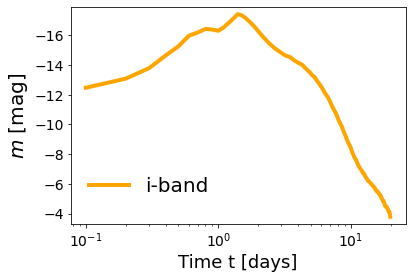

In [ ]:
!pip install matplotlib==3.1.1
import matplotlib.pyplot as plt

filt = 'i'
plt.semilogx(t, mag['{0}'.format(filt)], label='{0}-band'.format(filt), color='orange', linewidth=4.0)
plt.ylim(np.max(mag['{0}'.format(filt)])+0.5, np.min(mag['{0}'.format(filt)])-0.5) 
    
# general plotting settings
plt.xlabel('Time t [days]', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('$m$ [mag]', fontsize=20)
plt.yticks(fontsize=14)
plt.legend(prop={"size":20}, frameon=False, bbox_to_anchor=(0., 0.2, 1., .102)) # loc=0,


**b) Gamma-ray burst afterglow**

NMMA uses `afterglowpy` (Ryan et al. 2020), an open-source computational tool modeling forward shock synchrotron emission from relativistic blast waves as a function of jet structure and viewing angle. The model parameters are:
- isotropic kinetic energy $E$
- jet collimation angle $θ_c$
- viewing angle $θ_w$
- circumburst constant density $n$
- spectral slope of the electron distribution $p$
- fraction of energy imparted to the electrons by the shock $ϵ_E$
- fraction of energy imparted to the magnetic field $ϵ_B$


In [ ]:
from nmma.em.model import GRBLightCurveModel

t_day = np.arange(1., 950., 1.)
params = {
  'inclination_EM': 0.1,
  'log10_E0': 50.,
  'thetaCore': 0.05,
  'thetaWing': 0.01,
  'log10_n0':-4.5,
  'p':2.160,
  'log10_epsilon_e':-1.6, 
  'log10_epsilon_B':-2.,
  'luminosity_distance': 40,}

grb_model = nmma.em.model.GRBLightCurveModel(t_day, resolution=12, jetType=0) 

# note: this model does NOT require a grid file (SVD or neural network (NN))

In [ ]:
lbol_grb, mag_grb = grb_model.generate_lightcurve(t_day, params)

**c) Supernovae**

NMMA incorporates several models to generate and fit supernova afterglow light curves relying on models from [sncosmo](https://github.com/sncosmo/sncosmo). For example, the nugent-hyper model [(Levan et al. 2005)](https://arxiv.org/abs/astro-ph/0403450) used for SN Ib/c supernovae with the stretch and scale set to match the intrinsic (dereddened, rest frame)-band luminosity of SN 1998bw at maximum light. The main free parameter is:
- the absolute magnitude $S_{max}$


In [ ]:
tSN_min = 1 # days
tSN_max = 30 # days
tSN_dt = 0.1 # deltat
tSN = np.arange(tSN_min, tSN_max, tSN_dt)

params = {
  'supernova_mag_boost': 20, 
  'luminosity_distance': 40,}


SN_nugent = nmma.em.model.SupernovaLightCurveModel(tSN, model='nugent-hyper')

lbol_SN_nug, mag_SN_nug = SN_nugent.generate_lightcurve(tSN, params)

***Tasks:*** <br>
1) Explore the GRB afterglow model:<br>
   i. In which photometric bands/filters is a light curve generated?<br>
   ii. Plot the light curve for the X-ray-1keV band!

*2) Explore further models currently implemented in NMMA!<br>*
   i.  Which astrophysical processes are described by these models? <br>
   ii. On which parameters do these models depend and what are fiducial ranges? <br>

*3) Try to generate light curves for 3 chosen models!* <br>
   i.  Explore which models depend on grid files (SVD or neural network)! <br>
   ii. Explore for which filters these models generate light curves! <br>

# **3) Creating injected signals**

Here, we show how to generate injected signals for both: <br>
a) Gravitational-wave signals, and <br>
b) Electromagnetic signals


**What is needed:**
- a prior file (GW or EM), and 
- an EOS file (e.g. `nmma/example_files/eos/ALF2.dat`)

**Command arguments:**
- `-eos-file`, EOS file (columns: radius, mass, tidal deformability) 
- `-n`, referring to name of file
- `-s`, generation seed
- `-binary_type`, which type of astrophyiscal source (BNS / NSBH)
- `-e`, extension, i.e., output file type
- `-f`, name of output file
- `-duration`, duration of signal

**Output:**
- an injection file with extension of chosen type (`json`, `dat`)


### **3.1) GW injections**

*Run in terminal prompt*

In [ ]:
# nmma_create_injection --prior-file injec_alspin.prior -n 5 -s 42 --eos-file /nmma/example_files/eos/ALF2.dat --binary-type BNS -e json -f GWinj_ALFeos --duration 128

A simple prior file for injected GW signals with aligned spins (`chi_1` and `chi_2`) and neutron stars each having a mass of 1.2 $M_{\odot}$ could look like this:

```
mass_1 = 1.2
mass_2 = 1.2
mass_ratio =  Constraint(name='mass_ratio', minimum=0.125, maximum=1.)
chi_1 = bilby.gw.prior.AlignedSpin(name='chi_1', a_prior=Uniform(minimum=0, maximum=0.99))
chi_2 = bilby.gw.prior.AlignedSpin(name='chi_2', a_prior=Uniform(minimum=0, maximum=0.99))
luminosity_distance = PowerLaw(alpha=2, name='luminosity_distance', minimum=1., maximum=500.)
dec = Cosine(name='dec')
ra = Uniform(name='ra', minimum=0, maximum=2 * np.pi)
cos_theta_jn = Uniform(name='cos_theta_jn', minimum=-1, maximum=1)
psi = Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
phase =  Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic')
```





### **3.2) EM signal injections**

*Run in terminal prompt*

In [ ]:
# KN Inference - using the Metzger (Me2017) model 

#nmma_create_injection --prior-file /nmma/priors/Me2017.prior --eos-file /nmma/example_files/eos/ALF2.dat --binary-type BNS --n-injection 10 --original-parameters --extension json

***Tasks:*** <br>
*1) Try to generate an injection file for 20 injections for the following models!<br>*
   i.   `TrPi2018` - GRB afterglow model <br>
   ii.  `Bu2019lm` - Kilonova model <br>
   iii. binary neutron star GW injection with precessing spins and masses $m_{1,2}$ = $1.2 M_{\odot}$

# **4) Bayesian inference**

Statistical Bayesian inference is used to perform statistical parameter estimation on parameters $\vec{θ}$ of models $\mathcal{M}$ which describe astrophysical sources.

## **4.1) Gravitational-wave inference**

Under the assumption of stationary Gaussian noise, the GW likelihood $\mathcal{L}_{\rm{GW}}(\vec{\theta})$ that the data $d$ is a sum of noise and a GW signal $h$ with parameters $\vec{\theta}$ is given as

\begin{equation}
        \mathcal{L}_{\rm{GW}} \propto \exp\left(-\frac{1}{2}\langle d-h(\vec{\theta})|d-h(\vec{\theta})\rangle\right),\end{equation}

where the inner product $\langle a|b\rangle$ is defined as

\begin{equation}
        \langle a | b \rangle = 4\Re\int_{f_\textrm{low}}^{f_\textrm{high}}\frac{\tilde{a}(f)\tilde{b}^*(f)}{S_n(f)}df.
\end{equation}

and $\tilde{a}(f)$ is the Fourier transform of $a(t)$, ${}^*$ denotes complex conjugation, and $S_n(f)$ is the one-sided power spectral density of the noise. The choice of $f_{\rm{low}}$ and $f_{\rm{high}}$ depends on the type of binary that we are interested in.

***Sampler:***
- [Dynstey](https://dynesty.readthedocs.io/en/stable/) (default in bilby)

***A typical GW inference requires:***
- a config file
- a prior file
- data or injection file
- *optional:* eos files

***Main Commands:***
- `nmma_generation config.ini` - prepares files for Bayesian inference
- `nmma_analysis name_data_dump.pickle` - starting Bayesian inference


***Command arguments (see also: bilby, parallel-bilby packages):***
- `--nlive` - number of live points to explore the likelihood landscape
- `--maxmcmc` - maximum number of random walks 
- `--nact` - number of auto-correlation times to use before accepting a point
- `--label` - name of inference run
- `--outdir` - output directory name
- `--sampling-seed` - Random seed for sampling
- `--check-point-deltaT` - time interval for saving checkpoints

see also: https://lscsoft.docs.ligo.org/parallel_bilby/data_analysis.html

*Run in terminal prompt*

In [ ]:
# 1) generating Bayesian inference files
# nmma_generation config.ini

# 2) Starting Bayesian inference
# nmma_analysis outdir/data/<name_of_label>_data_dump.pickle --nlive 2048 --maxmcmc 10000 --nact 10 --label <name_of_run> --outdir outdir --sampling-seed 1234 --check-point-deltaT 14400

***Output:***
- posterior file
- checkpoint file
- log file


## **4.2) Electromagnetic signal inference**

In NMMA, the Bayesian inference of elctrogmatic signals such as kilonovae and GRB afterglows is based on the AB magnitude for a specific filter $j$, $m^{j}_{i}(t_i)$. We assume these measurements to be given as a time series at times $t_i$ with a corresponding statistical error $\sigma^{j}_{i} \equiv \sigma^{j}(t_i)$. 

The likelihood function $\mathcal{L}_{\rm{EM}}(\vec{\theta})$ then reads
\begin{equation}
    \mathcal{L}_{\rm{EM}} \propto \exp\left(- \frac{1}{2}\sum_{ij}\left(\frac{m^{j}_{i} - m^{j, \rm{est}}_{i}(\vec{\theta})}{\sigma^{j}_{i}}\right)^2\right), 
\end{equation}
where $m^{j, \rm{est}}_{i}(\vec{\theta})$ is the estimated AB magnitude for the parameters $\vec{\theta}$.

***Sampler:***
- PyMultinest ([repo](https://github.com/JohannesBuchner/PyMultiNest) and [paper](https://arxiv.org/abs/0809.3437))

***A typical EM inference requires:***
- a prior file
- data or injection file


***Main Command:***
- `light_curve_analysis` - starting EM Bayesian inference


***Command arguments:***
- `--model` - model (GRB, kilonova, Supernova model)
- `--interpolation_type` - interpolation type (`tensorflow`, `sklearn_gp`, `api_gp`)
- `--svd-path` - path to grid files (for SVD: `sklearn_gp` or `api_gp`; for NN grid: `tensorflow`)
- `--outdir` - output directory name
- `--label` - name of inference run
- `--trigger-time` - in Modified Julian time [days]
- `--data` - path to observational data file
- `--prior` - path to prior file
- `--tmin` - start time of EM signal 
- `--tmax` - end time of EM signal 
- `--dt` - time step 
- `--error-budget` - Additional systematic error in [mag] (default: 1)
- `--nlive` - number of live points in likelihood evaluation
- `--Ebv-max` - Maximum allowed value for exinction
 
see also: https://github.com/nuclear-multimessenger-astronomy/nmma/blob/main/nmma/em/analysis.py


*Run in terminal prompt*

In [ ]:
#mpiexec -np 8 light_curve_analysis --model Bu2019lm --interpolation_type tensorflow --svd-path /content/nmma/svdmodels --outdir outdir --label AT2017gfo_Bu2019lm --trigger-time 57982.5285236896 --data /content/drive/MyDrive/AT2017gfo_KNdominate.dat --prior /content/drive/MyDrive/AT2017gfo_gaussian_distance.prior --tmin 0 --tmax 14 --dt 0.1 --error-budget 1 --nlive 1024 --Ebv-max 0

The argument `mpiexec -np` defines the number of CPUs to be used for the simulation. The output will be an `outdir` directory, in which you will find the following files:
- posterior file
- plots: corner plot (best fitting lightcurves) 
- log files


Below, we show the result of the Bayesian Inference using the kilonova model `Bu2019lm` and observational data of AT2017gfo (using neural network files). 

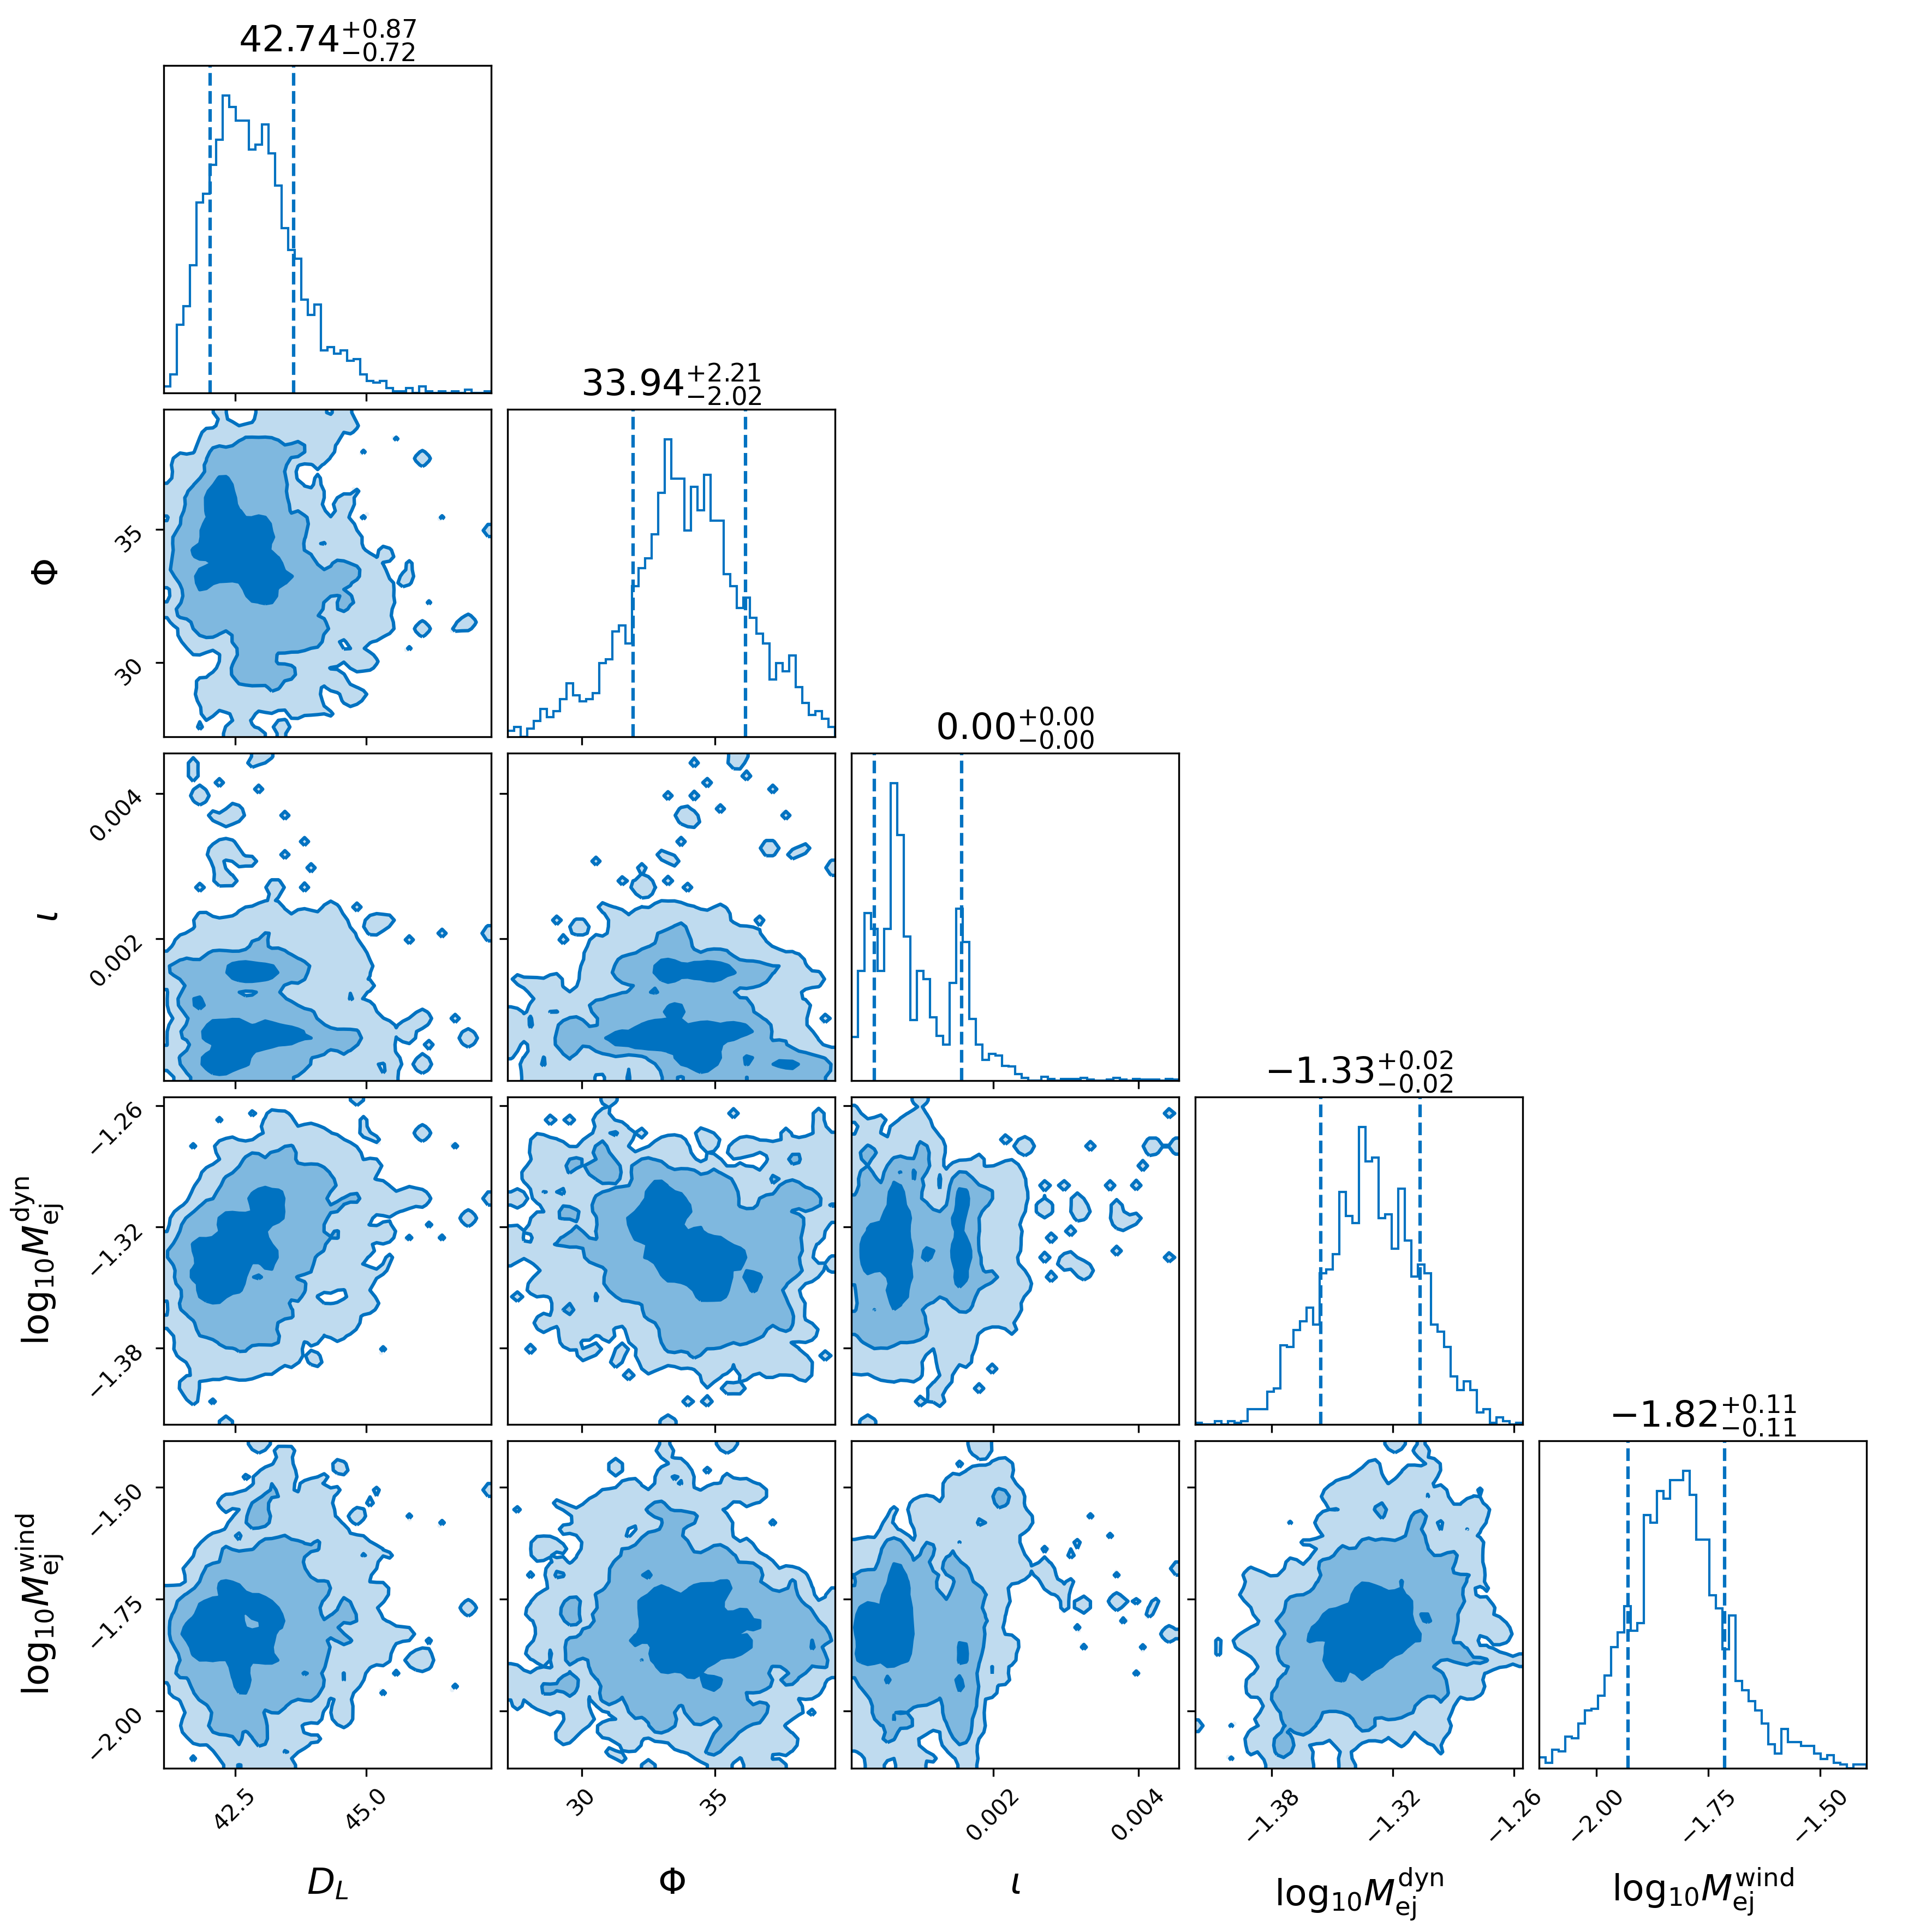

In [ ]:
from IPython.display import Image
Image("/figures/AT2017gfo_Bu2019lm_corner.png", width=700, height=700)

## **4.3) Joint Multi-Messenger Inference**

The joint parameter estimation in NMMA combins both, GW and EM likelihoods. The joint likelihood $\mathcal{L}$ is given by

\begin{equation}
    \mathcal{L}(\vec{\theta}) = \mathcal{L}_{\rm GW}(\vec{\theta}_{\rm GW}) \times \mathcal{L}_{\rm EM}(\vec{\theta}_{\rm EM}),
\end{equation}

where $\vec{\theta} = \{\vec{\theta}_{\rm GW}, \vec{\theta}_{\rm EM}\}$. 

**What can we run in NMMA?**

1) combination of GW + EM models (GRB + KN) <br>
2) combination of EM models (GRB + KN or GRB + SN or others)

An examplary result for a full joint Bayesian inference for the well-observed binary neutron star merger from 2017 is shown below. The joint parameter estimation combined information from messengers: 
- GW170817
- GRB170817A
- AT2017gfo

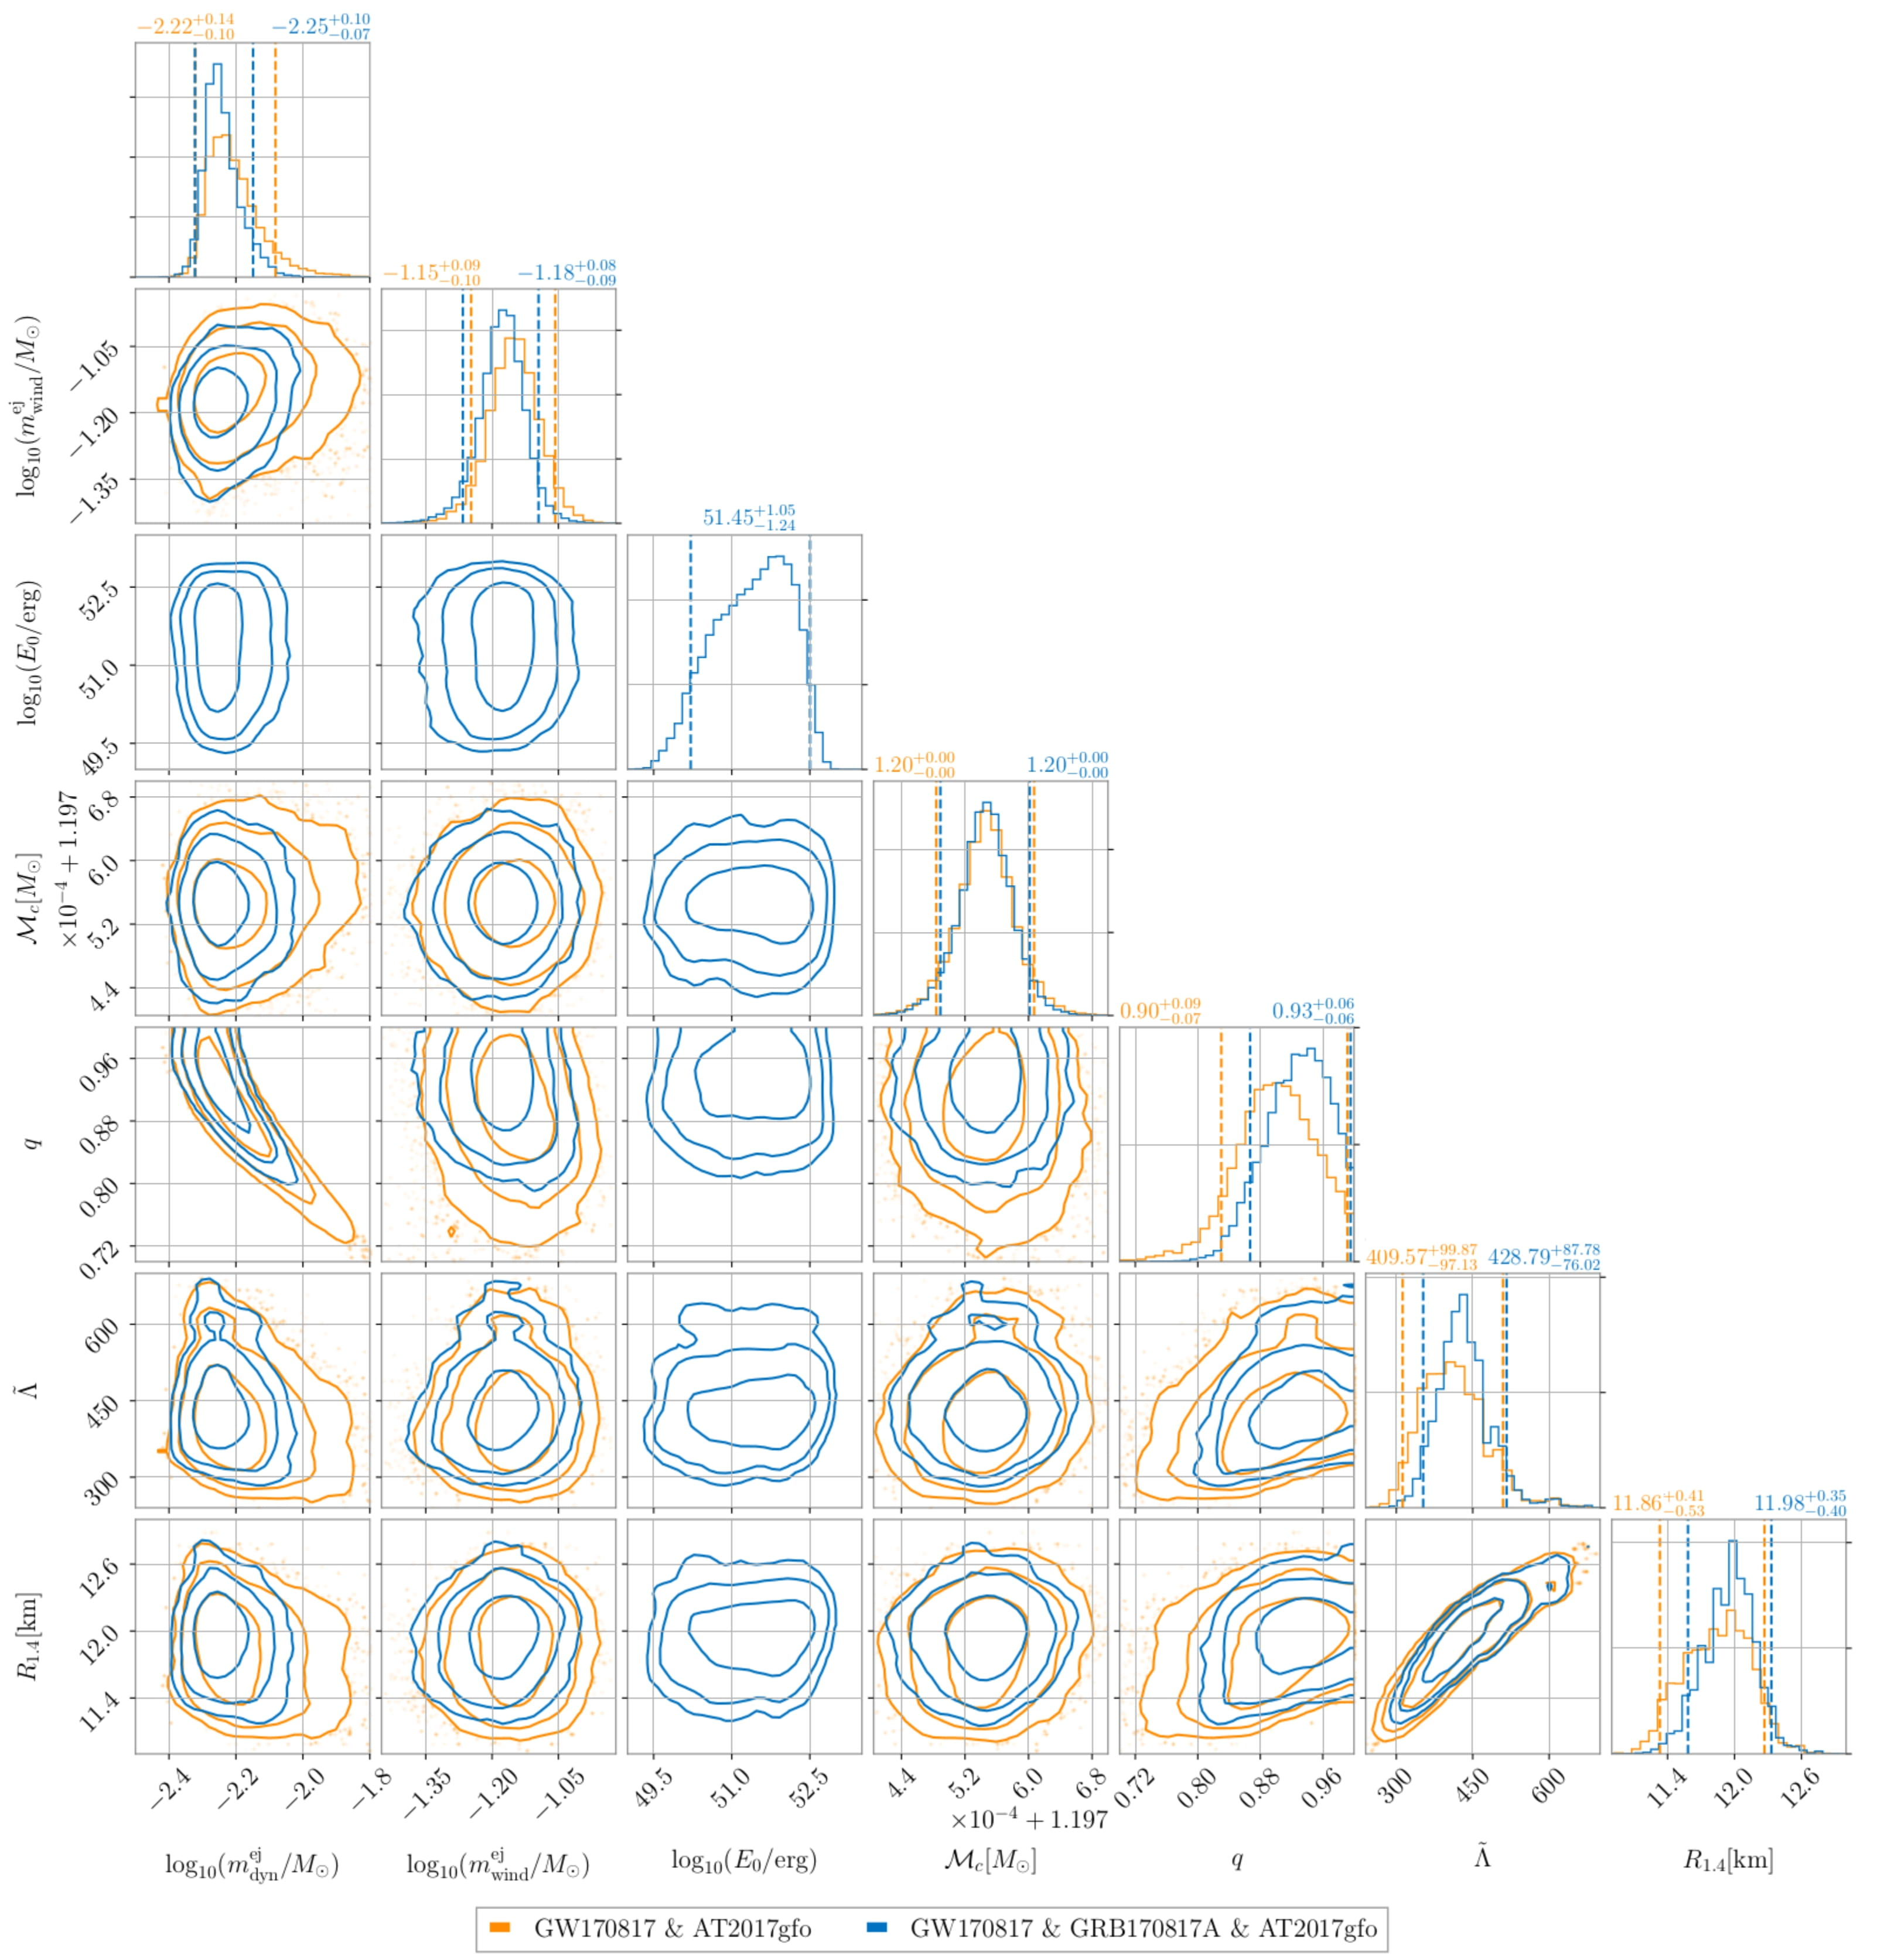

In [ ]:
Image("/figures/corner_comp_GWGRBKN_GWKN.jpg", width=1000, height=1000)

***Plot:*** Corner plot for the mass of the dynamic ejecta $m^{ej}_{dyn}$, the mass of the disk wind ejecta $m_{wind}$, $log_{10}$ of the GRB jet on-axis isotropic energy $log_{10} (E_0)$, the source-frame chirp mass $\mathcal{M}_c$, the mass ratio $q$, the mass-weighted tidal deformability $\tilde{Λ}$ and the radius of a 1.4 solar mass neutron star $R_{1.4}$ at 68%, 95% and
99% confidence. For the 1D posterior probability distributions, we mark the median (solid lines) and the 90% confidence interval (dashed lines) and report these above each panel. We show results that are based on the simultaneous analysis of GW170817&AT2017gfo (orange) and of GW170817&AT2017gfo&GRB170817A
(blue). [Pang et al., 2022]

### **4.3.1) Joint Inference for observed GW + GRB + KN signals**


***A typical joint inference on GW+GRB+KN signals requires:***
- a prior file (e.g., see [here](https://github.com/nuclear-multimessenger-astronomy/nmma/blob/main/example_files/prior/GW170817_AT2017gfo_GRB170817A.prior))
- data or injection file
- optional: EOS folder (including EOSs) and EOS weighting file


***Main Command:***
- `nmma_generation config.ini`
- `nmma_analysis outdir/data/label_data_dump.pickle`


***Command arguments:***
- `--nlive` - number of live points to explore the likelihood landscape
- `--maxmcmc` - maximum number of random walks 
- `--nact` - number of auto-correlation times to use before accepting a point
- `--label` - name of inference run
- `--outdir` - output directory name
- `--sampling-seed` - Random seed for sampling
- `--check-point-deltaT` - time interval for saving checkpoints



### **4.3.2) Joint Inference for observed EM signals (e.g. GRB + KN)**

***Task:***
- Go to this webpage: https://enlil.gw.physik.uni-potsdam.de/dokuwiki/doku.php?id=lc_comb_inference
- Try to run the combined inference for the example BNS case!
- Make sure to check your available computational resources! (adapt `mpiexec -np xx` to xx available cores)
- this command need to be run from your terminal prompt!